# Image Caption Generator 

**Author: Meeshawn Marathe**

**Date: 12/12/2022**

## Introduction

In this work, we perform the supervised learning of natural language caption generation from a set of images annotated with their corresponding captions. This task of generating captions is realised by constructing a multimodel neural network architecture that cascades CNN and LSTM models in order to perform feature extraction from images and text sequence learning from their corresponding captions respectively.
Transfer learning is utilized to extract salient features from the images (Flicker8K dataset) with the help of a pre-trained CNN model (InceptionV3 pre-trained on imagenet). Text features from the captions are obtained with the help of GloVe embeddings and text sequence learning is then achieved by providing the
glove embeddings for the vocabulary to the LSTM for language learning. Finally, text and image features are concatenated to input a neural network which is trained to achieve caption generation for unseen images.

## Source Code

### Defining model constants and importing necessary packages

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Nov  1 16:22:24 2022

@author: Meeshawn Marathe
"""

#%%  Import necessary packages
import numpy as np
import string
import matplotlib.pyplot as plt
import os
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.applications.xception import Xception, preprocess_input
from keras.models import Model, load_model
from keras.layers import Input, Dropout, Dense, LSTM, Embedding, Add
from tensorflow.keras.utils import load_img,img_to_array

from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#%% Defining Model Constants 

# Path to the images
IMAGES_PATH = './dataset/Flickr8k_Dataset/Flicker8k_Dataset'
IMAGES_FOLDER = os.getcwd() + IMAGES_PATH

# Path to image captions
CAPTIONS_PATH = './dataset/Flickr8k_text'
CAPTIONS_FOLDER = os.getcwd() + CAPTIONS_PATH

# Desired image dimensions
IMAGE_SIZE = (299, 299)

In [3]:
#%% Reading and storing the image filenames

def extractName(filename):
    file = open(filename, 'r')
    text = file.read()
    text = text.split('\n')
    file.close()
    return text    
    
#%%
train_imgs = extractName('./dataset/Flickr8k_text/Flickr_8k.trainImages.txt')
train_imgs = [x for x in train_imgs if x != '']

test_imgs = extractName('./dataset/Flickr8k_text/Flickr_8k.testImages.txt')
test_imgs = [x for x in test_imgs if x != '']

dev_imgs = extractName('./dataset/Flickr8k_text/Flickr_8k.devImages.txt')
dev_imgs = [x for x in dev_imgs if x != '']

### Image Feature Extraction

In [4]:
#%% Loading images and extracting final layer features/weights

def extractFinalLayer(IMAGES_FOLDER, img_name, model):
    # Convert all the images to size 299x299 as expected by the
    # inception v3 model
    img = load_img(os.path.join(IMAGES_FOLDER, img_name), target_size=IMAGE_SIZE)
    # Convert PIL image to numpy array of 3-dimensions
    x = img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess images using preprocess_input() from inception module
    x = preprocess_input(x)
    x = model.predict(x)
    # reshape from (1, 2048) to (2048, )
    x = np.reshape(x, x.shape[1])
    return x

#%%
# Create an instance of the Inception V3 network
model_xception = Xception(include_top=False, pooling='avg')

In [ ]:
# Creating a dictionary of image feature vector 6000x2048

dict_image_eigen_vector = {}
def featureExtractions(images):
    for image in tqdm(images):
        image_eigen_vectors = extractFinalLayer(IMAGES_FOLDER, image, model_xception)
        dict_image_eigen_vector[image] = image_eigen_vectors


featureExtractions(train_imgs)

In [ ]:
#%% Saving the 2048 length image Xception feature vector to a pickle file

with open('/content/drive/MyDrive/Final_Project/gil_strang_exception.pkl', 'wb') as f:
    pickle.dump(dict_image_eigen_vector, f)
f.close()

In [7]:
#%% Retreiving the 2048 length image Xception feature vector to a pickle file

with open('gil_strang_exception.pkl', 'rb') as f:
    dict_image_eigen_vector = pickle.load(f)
f.close()

### Text data pre-processing 1

In [8]:
#%% Read and store the image captions into a dictionary

file = open('./dataset/Flickr8k_text/Flickr8k.token.txt')
print('Reading and storing the image filenames and the corresponding captions\n' )

dict_descriptions = {}
for line in file:
    sentence = line.strip()
    sentence = sentence.split ('\t')   
    
    img_file_name = sentence[0].split('.')[0]
    caption = sentence[1]
    
    if dict_descriptions.get(img_file_name) == None:
        dict_descriptions[img_file_name] = []
     
    caption = 'startseq' + ' ' + caption + ' ' + 'endseq'
    dict_descriptions[img_file_name].append(caption)
    
file.close()
#%% Pre-processing/cleaning the captions:
maxLength = 0
print('Pre-processing and cleaning the captions')
for file, captions in dict_descriptions.items():
    for idx in range(len(captions)):       
        captions[idx] = captions[idx].lower()
        captions[idx] = captions[idx].translate(str.maketrans('', '', string.punctuation))
        captions[idx] = [word for word in captions[idx].split(' ') if len(word)>1]
        captions[idx] = [word for word in captions[idx] if word.isalpha()]
        captions[idx] = ' '.join(captions[idx])
        currLen = len(captions[idx].split(' '))                
        if currLen > maxLength:
                maxLength = currLen
print(maxLength)

#%% Create a dictionary of unique words:
vocabulary = {}

for key, captions in dict_descriptions.items():
    for caption in captions:
        for word in caption.split(' '):
            vocabulary[word] = vocabulary.get(word, 0) + 1

Reading and storing the image filenames and the corresponding captions

Pre-processing and cleaning the captions
34


In [9]:
print(len(vocabulary))

8764


### Text data pre-processing 2

In [ ]:
#%% Creating Word embeddings for all the words in the vocabulary:
    
glove_embeddings = {}
with open('./dataset/glove.6B/glove.6B.200d.txt', 'r', encoding='utf-8') as f:
    for line in tqdm(f):
        sentence = line.strip()
        sentence = sentence.split()
        word = sentence[0]
        feature_vector = sentence[1:]
        # print(word)
        glove_embeddings[word] = np.asarray(feature_vector, dtype='float32')
f.close()

#%% Word embeddings for all the unique words in the captions/vocabulary
dim_glove_vector = 200
count = 0
vocab_embeddings = np.zeros((len(vocabulary)+1, dim_glove_vector))
for word in tqdm(vocabulary):
    if word in glove_embeddings:
        vocab_embeddings[wrd2idx[word]] = glove_embeddings[word]
    else:
        count = count+1
#%%      

with open('/content/drive/MyDrive/Final_Project/LSTM_vocab_embeddings.pkl', 'wb') as f:
    pickle.dump(vocab_embeddings, f)
f.close()

In [11]:
with open('LSTM_vocab_embeddings.pkl', 'rb') as f:
    vocab_embeddings = pickle.load(f)
f.close()

In [12]:
#%% Create word-to-index and index-to-word mapping functions
wrd2idx = {}
idx2wrd = {}
idx = 1
for word in vocabulary:
    wrd2idx[word] = idx
    idx2wrd[idx] = word
    idx += 1

### Prepare inputs/outputs for Training

In [ ]:
#%% Create a function that prepares the inputs and outputs according to the
#   network configuration and for batch-processing. This function also 
#   extracts text sequences from captions and appends these with their 
#   corresponding image.

def data_prep(dict_descriptions, dict_image_eigen_vector, maxLength, num_batch_size):
    X1 = [] # Image input feature/eigen vector
    X2 = [] # Input sequence/partial captions
    Y  = [] # Target word
    
    n = 0
    while True:
        for file_name, feature_vector in dict_image_eigen_vector.items():
            n += 1
            
            captions = dict_descriptions[file_name.split('.')[0]]
            for caption in captions:
                seq = [wrd2idx[word] for word in caption.split() if word in wrd2idx]
                # Creating input-output data as per the NN config
                for idx in range(1, len(seq)):
                    partial_caption = seq[:idx]
                    target_word = seq[idx]
                    partial_caption = pad_sequences([partial_caption], maxlen=maxLength)[0]
                    target_word = to_categorical([target_word], num_classes=len(vocabulary)+1)[0]
                    X1.append(feature_vector) 
                    X2.append(partial_caption)
                    Y.append(target_word)
                    
            if n==num_batch_size:
                yield [[np.array(X1),np.array(X2)],np.array(Y)]
                X1, X2, Y  = list(), list(), list()
                n=0

In [ ]:
#%% Creating a data generator object to be fed while training the feedforward NN

final_generator = data_prep(dict_descriptions,dict_image_eigen_vector,maxLength,num_batch_size=3)

In [ ]:
#%% Testing the data generator function
inputs, outputs = next(final_generator)

print(inputs[0].shape)
print(inputs[1].shape)
print(outputs.shape)

### Hybrid Neural Network Configuration and Training

In [ ]:
#%% Define the hybrid network architecture
#
# [CNN + LSTM] -->> Feedforward NN


# NN model for image feature extraction
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# NN model for text sequence learning
inputs2 = Input(shape=(maxLength,))
dim_glove_vector = 200
vocab_size = len(vocabulary)+1
se1 = Embedding(vocab_size, dim_glove_vector, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# NN decoder model for feed forward
decoder1 = Add()([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Merging CNN and LSTM models into the feedforward NN
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
# Using the pre-trained weights from the embeddding layer 
# and freezing its training.
model.layers[2].set_weights([vocab_embeddings])
model.layers[2].trainable = False
# model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
# Training the feeforward model
num_epoch = 12
checkpoint_filepath = '/content/drive'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

for ep in range(1, num_epoch):
    print("run epoch {}".format(ep))
    model.fit_generator(generator=final_generator, steps_per_epoch=len(dict_image_eigen_vector), epochs=1)
    
model.save("model.h5")

run epoch 1


<ipython-input-10-943cf8413e5a>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=final_generator, steps_per_epoch=len(dict_image_eigen_vector), epochs=1)


6000/6000 [==============================] - 610s 101ms/step - loss: 3.8886 - accuracy: 0.2741
run epoch 2
6000/6000 [==============================] - 589s 98ms/step - loss: 3.0268 - accuracy: 0.3305
run epoch 3
6000/6000 [==============================] - 581s 97ms/step - loss: 2.7264 - accuracy: 0.3585
run epoch 4
6000/6000 [==============================] - 578s 96ms/step - loss: 2.5745 - accuracy: 0.3774
run epoch 5
6000/6000 [==============================] - 577s 96ms/step - loss: 2.4802 - accuracy: 0.3897
run epoch 6
6000/6000 [==============================] - 575s 96ms/step - loss: 2.4143 - accuracy: 0.3995
run epoch 7
6000/6000 [==============================] - 575s 96ms/step - loss: 2.3688 - accuracy: 0.4056
run epoch 8
6000/6000 [==============================] - 571s 95ms/step - loss: 2.3325 - accuracy: 0.4111
run epoch 9
6000/6000 [==============================] - 571s 95ms/step - loss: 2.3030 - accuracy: 0.4148
run epoch 10
6000/6000 [==============================] -

In [13]:
def generateCaption(photo, model, max_length, wordtoix, ixtoword):
    # start with 'stratseq'
    in_text = ['startseq']
    # iterate over the maximal length of description
    for s in range(max_length):
        seq = [wordtoix[i] for i in in_text]
        seq = pad_sequences([seq], maxlen=max_length)[0]
        in_put = [np.array([photo]), np.array([seq])]
       
        out_word = model.predict(in_put, verbose=0)
        # convert probability to integer
        out_word = np.argmax(out_word)
        # map ix to word
        out_word = ixtoword[out_word]
        # stop if we cannot map the word
        if out_word is None:
            break
        # append as input for generating the next word
        in_text.append(out_word)
        # stop if we predict the end of the sequence
        if out_word == 'endseq':
            break
    return in_text

In [14]:
model_ff = keras.models.load_model('model.h5')

In [15]:
model_ff.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 200)      1753000     ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_1[0][0]']                
                                                                                              

## Prediction Results

In [16]:
from PIL import Image

**Prediction on test image 1**

In [47]:
image = test_imgs[420]
image

'317109978_cb557802e1.jpg'

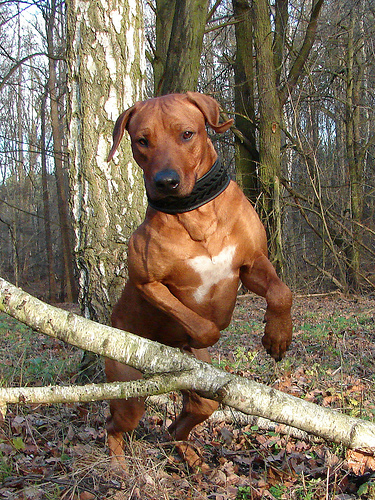

In [48]:
# filepath1 = '2654514044_a70a6e2c21.jpg'
filepath1 = '317109978_cb557802e1.jpg'
testImg1 = Image.open(IMAGES_PATH + '/' + filepath1)
testImg1

In [49]:
finalLayer_testImg1 = extractFinalLayer(IMAGES_FOLDER, filepath1, model_xception)

1/1 [==============================] - 0s 47ms/step


In [50]:
caption1 = generateCaption(finalLayer_testImg1, model_ff, maxLength, wrd2idx, idx2wrd)

In [51]:
caption1

['startseq',
 'brown',
 'dog',
 'is',
 'running',
 'through',
 'the',
 'grass',
 'endseq']

In [52]:
# Reference captions (gold truth) for testImg1:
dict_descriptions[filepath1.split('.')[0]]

['startseq brown and white pitbull with black collar is about to leap over branch endseq',
 'startseq brown dog climbs over fallen branch in wooded area endseq',
 'startseq brown dog hops over fallen tree branch endseq',
 'startseq brown dog is jumping over tree limb in wooded area endseq',
 'startseq brown dog with white mark in chest and black collar going over limb on ground endseq']

**Prediction on Test Image 2**

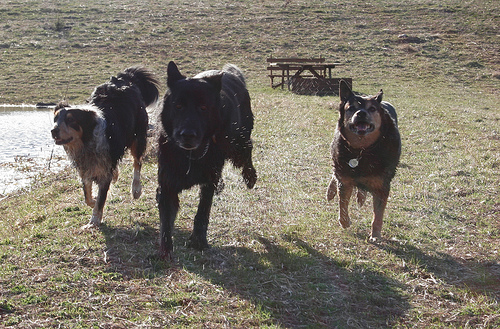

In [47]:
filepath2 = '3462454965_a481809cea.jpg'
testImg2 = Image.open(IMAGES_PATH + '/' + filepath2)
testImg2

In [48]:
finalLayer_testImg2 = extractFinalLayer(IMAGES_FOLDER, filepath2, model_xception)

1/1 [==============================] - 0s 34ms/step


In [50]:
caption2 = generateCaption(finalLayer_testImg2, model_ff, maxLength, wrd2idx, idx2wrd)

In [53]:
caption2

['startseq',
 'black',
 'and',
 'white',
 'dog',
 'running',
 'on',
 'the',
 'grass',
 'endseq']

In [55]:
# Reference captions (gold truth) for testImg2:
dict_descriptions[filepath2.split('.')[0]]

['startseq group of dogs runs beside pond through field endseq',
 'startseq several multicolored dogs running through the grass endseq',
 'startseq three black dogs two with tan markings are running along grass endseq',
 'startseq three dogs running through field endseq',
 'startseq three dogs run on scrubby grass lake and picnic table nearby endseq']

## Evaluation Metrics

For the evaluation part, we implemented ***BLEU ROUGE-1*** scores to compare 5 gold standard labels with the system prediction caption

In [68]:
!pip install rouge-score
from rouge_score import rouge_scorer

In [73]:
# Function to compute the BLEU ROUGE-1 (1-gram) score
scorer = rouge_scorer.RougeScorer(['rouge1'])
def Compute_Rouge_Score(test_images, dict_descriptions, model, modelXception, wrd2idx, idx2wrd):
    score_final = {}
    for img in test_images:
        captions = dict_descriptions[img.split('.')[0]]
        finalLayer = extractFinalLayer(IMAGES_FOLDER, img, modelXception)
        results = generateCaption(finalLayer, model, maxLength, wrd2idx, idx2wrd)
        hyp = [' '.join(results)]
        for (h, c) in zip(hyp, captions):
            score = scorer.score(h, c)
        score_final[img]= score
    return score_final   

In [74]:
final_output = Compute_Rouge_Score(test_imgs, dict_descriptions, model_ff, model_xception, wrd2idx, idx2wrd)

1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 53ms/step


In [75]:
import pandas as pd
df = pd.DataFrame.from_dict(final_output)
df.to_csv('final_output.csv' , index = True)

In [80]:
rouge_testImg1 = final_output[filepath1]
rouge_testImg1

{'rouge1': Score(precision=0.8, recall=0.5714285714285714, fmeasure=0.6666666666666666)}

In [81]:
rouge_testImg2 = final_output[filepath2]
rouge_testImg2

{'rouge1': Score(precision=0.2, recall=0.2, fmeasure=0.20000000000000004)}